In [34]:
%%capture
%pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels mpl_toolkits

In [35]:
#### Import all the needed packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting tool
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, r2_score

Reading and formatting the csv and dropping outliers 

In [36]:
csvFilePath = 'acc_data.csv'
df = pd.read_csv(csvFilePath)

### Standardized values
q = 0
r = 0.1 
m = 50

### Filter junk values and best_beta
df = df[(df['best_beta'] >= 0.57) & (df['m'] == m)]

### Make sure columns are numeric
numeric_columns = ['T', 'm', 'sigma', 'H', 'S0', 'K', 'price_iter']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

## Add the new paremeters
df['sigma_sqrt_T'] = df['sigma'] * np.sqrt(df['T'])
df['H_log'] = abs(np.log(df['H'] / df['S0']))


Formula for calculating the proudct between sigma*sqrt(delta_T)

In [37]:
def calc_product(sigma, T):
    return sigma*np.sqrt(T/m)

Formulas from the Book

In [38]:
def get_parameter_values(S0, K, T, r, q, sigma): 
    # d1 and d2 
    d1 = (np.log(S0/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
       
    # Lambda value 
    lambda_ = (r - q + 0.5 * sigma**2) / sigma**2
    
    # Vanilla call value
    c = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) 
    
    return lambda_, c

def down_and_call_book(S0, K, T, r, q, sigma,H, H_down, H_up):
    
    # Values for the different functions 
    lambda_, c = get_parameter_values(S0, K, T, r, q, sigma)
    
    # Value for the down and out
    y = np.log(H_down**2 / (S0*K)) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    
    # Values for the down and in 
    x1 = np.log(S0/H_up) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)
    y1 = np.log(H_up/S0) / (sigma * np.sqrt(T)) + lambda_ * sigma * np.sqrt(T)

    # Calculate option values for call
    if H <= K:
        #Down and out
        cdi = S0 * np.exp(-q * T) * (H_down/S0)**(2*lambda_) * norm.cdf(y) - K * np.exp(-r * T) * (H_down/S0)**(2*lambda_ - 2) * norm.cdf(y - sigma * np.sqrt(T))
        cdo = c  - cdi
        return cdo
    else:
        #Down and in
        cdo = S0 * np.exp(-q * T) * norm.cdf(x1) - K * np.exp(-r * T) * norm.cdf(x1 - sigma * np.sqrt(T)) 
        - S0 * np.exp(-q * T) * (H_up/S0)**(2*lambda_) * norm.cdf(y1) + K * np.exp(-r * T) * (H_up/S0)**(2*lambda_ - 2) * norm.cdf(y1 - sigma * np.sqrt(T))
        cdi = c - cdo
        
        return cdi


Regression line for beta increase point

Processed 72 combinations, obtained 72 valid H values.
Quadratic model: y = -3.6948e+00x^2 + 1.5892e+00x + -5.4973e-03 (R² = 0.9559)
Logistic model: y = 1.5609e-01 / (1 + exp(-3.2385e+01(x - 6.3465e-02))) (R² = 0.9551)


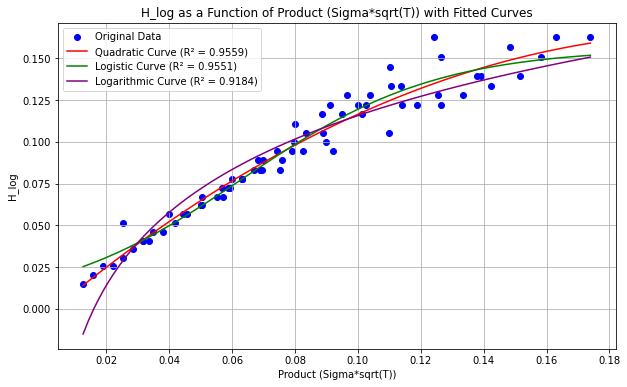

In [39]:
# Quadratic model function
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

# Logistic model function
def logistic_model(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Logarithmic model function
def logarithmic_model(x, a, b):
    return a + b * np.log(x)

### Function for finding strictly increase but with the H_log version instead
def is_decreasing(arr):
    return all(arr[i] <= arr[i + 1] for i in range(len(arr) - 1))

def find_strictly_decrease(data, T_val, sigma_val):
    df = data[(data['sigma'] == sigma_val) & (data['T'] == T_val)]
    sorted_data = df.sort_values(by='H_log', ascending=False)
    
    if df.empty:
        return 0
    
    for i in range(len(sorted_data)):
        split_array = sorted_data.iloc[i:]
        mapped_numbers = split_array['error_percent'].astype(float).tolist()
        if is_decreasing(mapped_numbers):
            return sorted_data.iloc[i]['H_log']
            
    return 0

# Extract unique values of sigma and T from the DataFrame
unique_sigmas = df['sigma'].unique()
unique_Ts = df['T'].unique()
#unique_ms = df['m'].unique()

# Sort the arrays in case order matters for your calculations
unique_sigmas.sort()
unique_Ts.sort()

h_values = []  # Store H values
products = []  # Store corresponding product values
count = 0

# Iterate over all combinations of unique sigma and T values
for T in unique_Ts:
    for sigma in unique_sigmas:
        H_value = find_strictly_decrease(df, T, sigma)
        count += 1

        # Assuming find_strictly_decrease returns a value where positive indicates a valid result
        if float(H_value) > 0:
            h_values.append(H_value)
            products.append(calc_product(sigma, T))

print(f"Processed {count} combinations, obtained {len(h_values)} valid H values.")

# Convert lists to numpy arrays for curve fitting
h_values = np.array(h_values)
products = np.array(products)

# Fit the quadratic model to the data
popt_quad, _ = curve_fit(quadratic_model, products, h_values)
predicted_values_quad = quadratic_model(products, *popt_quad)
r_squared_quad = r2_score(h_values, predicted_values_quad)

# Fit the logistic model to the data
popt_logistic, _ = curve_fit(logistic_model, products, h_values, p0=[max(h_values), 1, np.median(products)])
predicted_values_logistic = logistic_model(products, *popt_logistic)
r_squared_logistic = r2_score(h_values, predicted_values_logistic)

# Fit the logarithmic model to the data, excluding non-positive values
positive_products = products[products > 0]
positive_h_values = h_values[products > 0]
popt_log, _ = curve_fit(logarithmic_model, positive_products, positive_h_values)
predicted_values_log = logarithmic_model(positive_products, *popt_log)
r_squared_log = r2_score(positive_h_values, predicted_values_log)

# Values to pass to the indicator function
L_fitted, k_fitted, x0_fitted = popt_logistic

# Plot the original data
plt.figure(figsize=(10, 6))
plt.scatter(products, h_values, color='blue', label='Original Data')

# Generate x values for prediction
x_fit = np.linspace(min(products), max(products), 100)

# Plot the quadratic fitted curve
y_fit_quad = quadratic_model(x_fit, *popt_quad)
plt.plot(x_fit, y_fit_quad, color='red', label=f'Quadratic Curve (R² = {r_squared_quad:.4f})')

# Plot the logistic fitted curve
y_fit_logistic = logistic_model(x_fit, *popt_logistic)
plt.plot(x_fit, y_fit_logistic, color='green', label=f'Logistic Curve (R² = {r_squared_logistic:.4f})')

# Plot the logarithmic fitted curve (ensure x_fit is positive)
positive_x_fit = x_fit[x_fit > 0]
y_fit_log = logarithmic_model(positive_x_fit, *popt_log)
plt.plot(positive_x_fit, y_fit_log, color='purple', label=f'Logarithmic Curve (R² = {r_squared_log:.4f})')

# Fit the quadratic model to the data
popt_quad, _ = curve_fit(quadratic_model, products, h_values)
predicted_values_quad = quadratic_model(products, *popt_quad)
r_squared_quad = r2_score(h_values, predicted_values_quad)
print(f"Quadratic model: y = {popt_quad[0]:.4e}x^2 + {popt_quad[1]:.4e}x + {popt_quad[2]:.4e} (R² = {r_squared_quad:.4f})")

# Fit the logistic model to the data
popt_logistic, _ = curve_fit(logistic_model, products, h_values, p0=[max(h_values), 1, np.median(products)])
predicted_values_logistic = logistic_model(products, *popt_logistic)
r_squared_logistic = r2_score(h_values, predicted_values_logistic)
print(f"Logistic model: y = {popt_logistic[0]:.4e} / (1 + exp(-{popt_logistic[1]:.4e}(x - {popt_logistic[2]:.4e}))) (R² = {r_squared_logistic:.4f})")

# Fit the logarithmic model to the data
positive_products = products[products > 0]
positive_h_values = h_values[products > 0]
popt_log, _ = curve_fit(logarithmic_model, positive_products, positive_h_values)
predicted_values_log = logarithmic_model(positive_products, *popt_log)
r_squared_log = r2_score(positive_h_values, predicted_values_log)

# Add titles and labels
plt.title('H_log as a Function of Product (Sigma*sqrt(T)) with Fitted Curves')
plt.xlabel('Product (Sigma*sqrt(T))')
plt.ylabel('H_log')
plt.legend()
plt.grid(True)
plt.show()

# Quadratic model: y = -7.3896e-02x^2 + 2.2475e-01x + -5.4974e-03 (R² = 0.9559)
# Logistic model: y = 1.5609e-01 / (1 + exp(-4.5799e+00(x - 4.4876e-01))) (R² = 0.9551)"""

Regression line for the last value of Beta

Processed 65 combinations.
Logistic model: y = 7.1432e-01 / (1 + exp(-3.2172e+01(x - -6.4396e-02))) (R² = 0.9466)
Quadratic model: y = -2.3670e+00x^2 + 6.5777e-01x + 6.6895e-01 (R² = 0.9043)


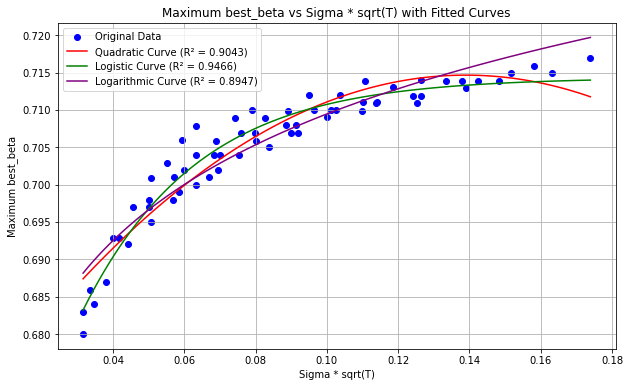

In [40]:
# Quadratic model function
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

# Logistic model function
def logistic_model(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Logarithmic model function
def logarithmic_model(x, a, b):
    return a + b * np.log(x)

# Extract unique values of 'T' and 'sigma' from the DataFrame
unique_Ts = df['T'].unique()
unique_Sigmas = df['sigma'].unique()

# Sort the arrays in case order matters for your calculations
unique_Ts.sort()
unique_Sigmas.sort()

x_values = []  # Store x values
y_values = []  # Store y values

# Iterate over unique combinations
for T in unique_Ts:
    for sigma in unique_Sigmas:
        # Filter dataframe for the current combination
        subset_df = df[(df['T'] == T) & (df['sigma'] == sigma)]
        
        # Calculate the product of Sigma and sqrt(T)
        x = calc_product(sigma, T)
        
        # Find the maximum value of 'best_beta' in this subset
        y = subset_df['best_beta'].max()
        
        # Append the values to the lists
        if y > 0.68 and y < 0.8: 
            x_values.append(x)
            y_values.append(y)

print(f"Processed {len(x_values)} combinations.")

# Convert lists to numpy arrays for curve fitting
x_values = np.array(x_values)
y_values = np.array(y_values)

# Fit the quadratic model to the data
popt_quad, _ = curve_fit(quadratic_model, x_values, y_values)
predicted_values_quad = quadratic_model(x_values, *popt_quad)
r_squared_quad = r2_score(y_values, predicted_values_quad)

# Fit the logistic model to the data
popt_logistic, _ = curve_fit(logistic_model, x_values, y_values)
predicted_values_logistic = logistic_model(x_values, *popt_logistic)
r_squared_logistic = r2_score(y_values, predicted_values_logistic)

# Fit the logarithmic model to the data
popt_log, _ = curve_fit(logarithmic_model, x_values, y_values)
predicted_values_log = logarithmic_model(x_values, *popt_log)
r_squared_log = r2_score(y_values, predicted_values_log)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, color='blue', label='Original Data')

# Generate x values for prediction
x_fit = np.linspace(min(x_values), max(x_values), 100)

# Plot the quadratic fitted curve
y_fit_quad = quadratic_model(x_fit, *popt_quad)
plt.plot(x_fit, y_fit_quad, color='red', label=f'Quadratic Curve (R² = {r_squared_quad:.4f})')

# Plot the logistic fitted curve
y_fit_logistic = logistic_model(x_fit, *popt_logistic)
plt.plot(x_fit, y_fit_logistic, color='green', label=f'Logistic Curve (R² = {r_squared_logistic:.4f})')

# Plot the logarithmic fitted curve
y_fit_log = logarithmic_model(x_fit, *popt_log)
plt.plot(x_fit, y_fit_log, color='purple', label=f'Logarithmic Curve (R² = {r_squared_log:.4f})')

#### Print the model equations
print(f"Logistic model: y = {popt_logistic[0]:.4e} / (1 + exp(-{popt_logistic[1]:.4e}(x - {popt_logistic[2]:.4e}))) (R² = {r_squared_logistic:.4f})")
print(f"Quadratic model: y = {popt_quad[0]:.4e}x^2 + {popt_quad[1]:.4e}x + {popt_quad[2]:.4e} (R² = {r_squared_quad:.4f})")

# Add titles and labels
plt.title('Maximum best_beta vs Sigma * sqrt(T) with Fitted Curves')
plt.xlabel('Sigma * sqrt(T)')
plt.ylabel('Maximum best_beta')
plt.legend()
plt.grid(True)
plt.show()



Function for estimating beta as a function

In [41]:
### Barrier engineer method
def regression_beta_estimate(T, sigma, H, S0):
    beta_start = 0.5826
    Sigma_sqrt_T = calc_product(sigma, T)

    #### TODO find this as a function of 
    #beta_end = 0.7174 ### Make this a function of sigma*sqrt(T) maybe over m
    beta_end = 0.71432 / (1 + np.exp(-4.5498*(Sigma_sqrt_T + 0.45534)))
     
    ### This is from the reg of increase point both Logistic and quadratic can be used
    #H_log_start =  -(7.3896e-02)*Sigma_sqrt_T**2 + (2.2475e-01)*Sigma_sqrt_T + -5.4974e-03
    H_log_start = 0.15609 / (1 + np.exp(-4.5799*(Sigma_sqrt_T - 0.4876)))
    
    H_start_increase = round(S0 * np.exp(-H_log_start))  # Determine the start of increase
    H_end = S0 - 1

    # Start with a constant beta
    beta = beta_start

    # If we've reached the start of the increase, switch to the polynomial curve
    if H >= H_start_increase:
        # These are placeholders and should be solved based on your specific conditions
        a = (beta_end - beta_start) / ((H_end - H_start_increase)**2)
        b = -2 * a * H_start_increase
        c = beta_start + a * H_start_increase**2
        
        # Polynomial growth formula
        beta = a * H**2 + b * H + c

    return beta

# Function to adjust the barrier for discrete monitoring
def adjusted_barrier_estimate(T, H, S0,sigma, m):
    
    # dT should be here, it "is the time between monitoring instants", p.325, also stated in book from michael at p.628
    delta_T = T / m
    beta = regression_beta_estimate(T, sigma, H, S0)

    ### adjust the beta value
    H_adj_down = H * np.exp(-1 * beta * sigma * np.sqrt(delta_T))
    H_adj_up = H * np.exp(beta * sigma * np.sqrt(delta_T))

    return H_adj_down, H_adj_up

Plot the difference between beta constant and beta function

Maximum Error - Original Method: 13.4592%
Maximum Error - Custom Engineer: 7.2536%


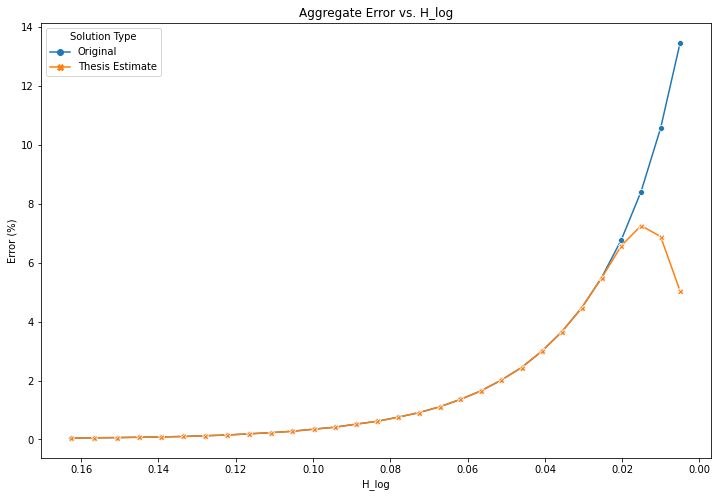

In [42]:
# Initialize a list to store error calculations
errors = []

for index, row in df.iterrows(): 
    # Extract necessary values from the row
    T, H, S0, K, sigma = row['T'], row['H'], row['S0'], row['K'], row['sigma']
    H_log = abs(np.log(row['H']/row['S0']))

    # Engineering solution
    beta_engineer = regression_beta_estimate(T, sigma, H, S0)  # Get beta for engineering estimate
    H_down_engineer, H_up_engineer = adjusted_barrier_estimate(T, H, S0,sigma, m)
    price_engineer = down_and_call_book(S0, K, T, r, q, sigma, H, H_down_engineer, H_up_engineer)
    
    # Assuming price_original and price_iter are columns in df representing original and Monte Carlo prices
    price_mc = row['price_iter']
    error_original = round(abs(((price_mc - row['price_adj']) / price_mc) * 100), 4)
    error_estimate = round(abs(((price_mc - price_engineer) / price_mc) * 100), 4)
        
    errors.append({'H_log': H_log, 'Error': error_original, 'Type': 'Original'})
    errors.append({'H_log': H_log, 'Error': error_estimate, 'Type': 'Thesis Estimate'})

    best_beta = row['best_beta']


# Convert errors list to DataFrame for plotting
df_errors = pd.DataFrame(errors)

# Aggregate errors by H_log and Type
df_agg = df_errors.groupby(['H_log', 'Type'], as_index=False)['Error'].mean()

# Find the maximum error values for each method
max_error_original = df_agg[df_agg['Type'] == 'Original']['Error'].max()
max_error_estimate = df_agg[df_agg['Type'] == 'Thesis Estimate']['Error'].max()

print(f"Maximum Error - Original Method: {max_error_original:.4f}%")
print(f"Maximum Error - Custom Engineer: {max_error_estimate:.4f}%")

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_agg, x='H_log', y='Error', hue='Type', style='Type', markers=True, dashes=False)
plt.title('Aggregate Error vs. H_log')
plt.xlabel('H_log')
plt.ylabel('Error (%)')
plt.legend(title='Solution Type')
plt.gca().invert_xaxis()  # Invert the x-axis to have the largest H_percent start on the left
plt.show()